<a href="https://colab.research.google.com/github/ltbngoc7/PdM-test/blob/main/1D_CNN_Model_For_Bearings_Fault_Diagnosis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Multiclass Classification For Bearing Fault Diagnosis

Bearing fault diagnosis has been a challenge in the monitoring activities of rotating machinery, and it's receiving more and more attention. The conventional fault diagnosis methods usually extract features from the waveforms or spectrums of vibration signals in order to correctly classify faults.

# 1. Introduction
This notebook shows the study of the [CWRU Bearing Dataset](https://csegroups.case.edu/bearingdatacenter/home), which contains data of normal and fault bearings. Artificial defects of different diameters (0.007 ~ 0.028 Inches) are manufactured at different locations of the bearings: inner raceway(IR), outer raceway(OR) and ball(B) defects.

Vibration data was recorded for motor loads of 0 to 3 hp (motor speed of 1797 to 1720 RPM) using accelerometers at the drive end (DE) and fan end (FE) and the data is stored as Matlab files. The sampling rate is 12 kHz and each Matlab file contains between ~120k to ~240k sample points. For more information please refer to the [website](https://csegroups.case.edu/bearingdatacenter/home).

This study focuses on the classification of the drive end bearing defects using only the signal data at **DE**. It is a **multiclass classification** problem. The input is the vibration signal data at DE and the output is the type of defects:
- 0 : Normal (N),
- 1 : Fault at Ball (B),
- 2 : Fault at Inner Raceway (IR),
- 3 : Fault at Outer Raceway (OR),



In [7]:
import errno, os
import requests
import scipy.io as sio
import numpy as np

from os import listdir
from os.path import isfile, join
from zipfile import ZipFile
from sklearn.model_selection import train_test_split

# Pytorch
import torch
from torch import nn
from torch.nn import functional as F
from torch import Tensor
from torch.utils.data import TensorDataset, DataLoader
from torch import optim
from torch.nn.modules.loss import CrossEntropyLoss

# Others
from IPython.core.debugger import set_trace
from pathlib import Path


In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 2. Download the dataset - CWRU

The dataset is downloaded from the [Github](https://github.com/Abdulhamid97Mousa/CWRU-dataset-1) repository.                                            
`I Here by admit that i haven't put the files in the correct order by myself, but instead taken the dataset already built structure from this person:` [Contact-Card](https://github.com/s-whynot).
  
The dataset has several matlab files where the name is just a number (such as "118.mat"). It has information such as
1. **State** -
     - `N` for *normal* state, not damaged
     - `B` for *ball* damage
     - `IR` for *inner raceway* damage
     - `OR` for *outer raceway* damage
2. **Fault Diameter** -
    - `007` for 0.007 inch damage
    - `014` for 0.014 inch damage
    - `021` for 0.021 inch damage
    - `028` for 0.028 inch damage  
    the unit 'mils' is 1/1000th of an inch
3. **Position of the sensor**
    - *3*, *6*, *12* for *outer raceway* faults located at 3 o’clock, at 6 o’clock and at 12 o’clock respectively of the load zone
4. **Load** can be:
    - *0*, *1*, *2*, *3* for different motor load conditions in Horsepower (HP)

In [9]:
print(os.getcwd())
filename = os.path.join(os.getcwd(), 'repo.zip')
print(filename)

/content
/content/repo.zip


In [10]:
url = 'https://github.com/Abdulhamid97Mousa/CWRU_DATASETS_ABCD/archive/refs/heads/main.zip'

r = requests.get(url)

print(filename)

with open(filename, 'wb') as f:
    f.write(r.content)

file_name = "/content/repo.zip"
with ZipFile(file_name, 'r') as zip:
    # printing all the contents of the zip file

    # extracting all the files
    print('Extracting all the files now...')
    zip.extractall()
    print('Finished Extracting!')

/content/repo.zip
Extracting all the files now...
Finished Extracting!


# 3. Edit the downloaded data

Using the data collected at the *Drive End*, which is labeled as the code `DE`, this function picks up the time signal from a file. For the given code, a regex is made on the dictionary keys, looking for the the code and ignoring the rest of the suffix.

The function also converts the unit to SI.

In [11]:
def acceleration_time_signal(dict_1, code):
    """
    load the time series in the file and convert units in SI
    file= 'filename' from the ./dataset/ folder
    code= ' DE' or 'FE', other code will give error
    """
    import re
    try:
        for key in dict_1:
            # print(key)
            if re.findall(rf"({code})", key):
                dict_code = key
        #inches to meter
        unit_conv = 0.0254
        x = dict_1[dict_code] * unit_conv
        return x
    except:
        print('File does not exist or code wrong. Code must be either "DE or "FE" ')

- 3 different functions are necessary to process the files and the data
- All subfolders scanned recursively with the function `fast_scandir`

In [12]:
def Read_MAT_files_from_folders(file_path, files_list, code):
  G_data = []
  for i in range(len(files_list)):
    data = sio.loadmat(os.path.join(file_path, files_list[i]))
    sig = acceleration_time_signal(data, code)
    # print('what is signal type and sig len and signal shape', type(sig), len(sig), sig.shape)
    G_data.append(sig)

  G_data = np.vstack(G_data).flatten()
  # print("what is G_data", G_data)
  return G_data

def Percent_data_split(array_1, array_2, percent_1 = 10, index_1 = False):
  if index_1 == False:
    #splitting FE data by percent
    len_n = array_1.shape[0]
    percent_true = percent_1/100
    x = int(percent_true*len_n) #% split
    data_percent, data_rest = np.split(array_1, [x])
  else:
    #splitting array_1 data by percent of array_2 data
    len_n = array_2.shape[0]
    percent_true = percent_1/100
    x = int(percent_true*len_n) #% split
    data_percent, data_rest = np.split(array_1, [x])

  return data_percent, data_rest

def fast_scandir(dirname):
    subfolders= [f.path for f in os.scandir(dirname) if f.is_dir()]
    for dirname in list(subfolders):
        subfolders.extend(fast_scandir(dirname))

    return subfolders

### 3.1 Normal Acceleration data
CWRU DE

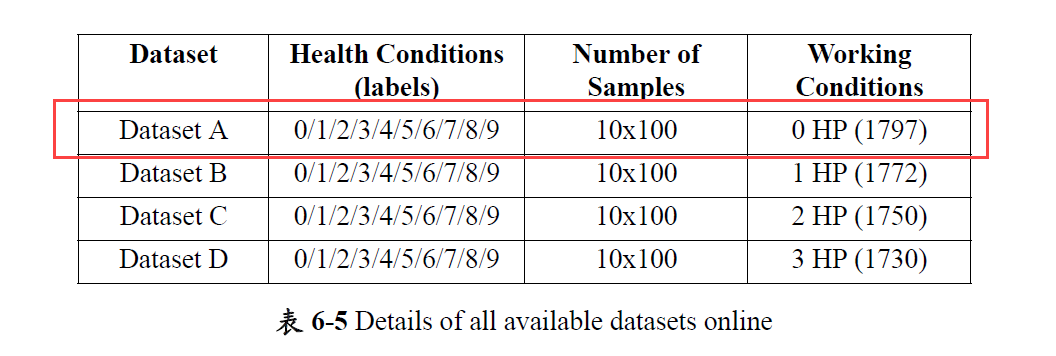

In [13]:
#12k Normal Signal for DE
file_path_1 = '/content/CWRU_DATASETS_ABCD-main/Dataset_A_1797/Normal'

onlyfiles_1 = [f for f in listdir(file_path_1) if isfile(join(file_path_1, f))]

print(onlyfiles_1)
print(type(onlyfiles_1))
print(len(onlyfiles_1))

G_data_N_DE_DATASET_A = Read_MAT_files_from_folders(file_path_1, onlyfiles_1, "DE")

print(G_data_N_DE_DATASET_A.shape)
print(type(G_data_N_DE_DATASET_A))

['97_Normal_0.mat']
<class 'list'>
1
(243938,)
<class 'numpy.ndarray'>


### 3.2 Faulty bearing data at DE: 12000 Hz DE  
`12k is the sampling rate fs`
1. B,
2. IR,
3. OR

In [14]:
#12k DE data load
file_path_2 = '/content/CWRU_DATASETS_ABCD-main/Dataset_A_1797/12k_Drive_End_Bearing_Fault_Data'
subfolder_path = fast_scandir(file_path_2)

G_data_OR_007_DE = []
G_data_OR_021_DE = []

for i in range(3, len(subfolder_path), 1):
  dir_1 = subfolder_path[i]
  print(subfolder_path[i])
  #B
  if 'B/' in dir_1:
    onlyfiles_2_1 = [f for f in listdir(dir_1) if isfile(join(dir_1, f))]

    if '007' in dir_1:
    #007
      G_data_B_007_DE = Read_MAT_files_from_folders(dir_1, onlyfiles_2_1, "DE")

    elif '014' in dir_1:
    #014
      G_data_B_014_DE = Read_MAT_files_from_folders(dir_1, onlyfiles_2_1, "DE")

    elif '021' in dir_1:
    #021
      G_data_B_021_DE = Read_MAT_files_from_folders(dir_1, onlyfiles_2_1, "DE")

    # else:
    # #028
    #   G_data_B_028_DE = Read_MAT_files_from_folders(dir_1, onlyfiles_2_1, "DE")
    #   print(onlyfiles_2_1)



  #IR
  elif 'IR/' in dir_1:
    onlyfiles_2_2 = [f for f in listdir(dir_1) if isfile(join(dir_1, f))]

    if '007' in dir_1:
    #007
      G_data_IR_007_DE = Read_MAT_files_from_folders(dir_1, onlyfiles_2_2, "DE")
    elif '014' in dir_1:
    #014
      G_data_IR_014_DE = Read_MAT_files_from_folders(dir_1, onlyfiles_2_2, "DE")
    elif '021' in dir_1:
    #021
      G_data_IR_021_DE = Read_MAT_files_from_folders(dir_1, onlyfiles_2_2, "DE")
    # else:
    # #028
    #   G_data_IR_028_DE = Read_MAT_files_from_folders(dir_1, onlyfiles_2_2, "DE")


  #OR
  elif 'OR/' in dir_1:

    onlyfiles_2_3 = [f for f in listdir(dir_1) if isfile(join(dir_1, f))]

    if '007' in dir_1:

      #007
      for i in range(len(onlyfiles_2_3)):
        data_OR_007 = sio.loadmat(os.path.join(dir_1, onlyfiles_2_3[i]))
        or_sig_007 = acceleration_time_signal(data_OR_007, code='DE')
        G_data_OR_007_DE.append(or_sig_007)

      #014
    elif '014' in dir_1:
      G_data_OR_014_DE = Read_MAT_files_from_folders(dir_1, onlyfiles_2_3, "DE")


      #021
    else:
      for i in range(len(onlyfiles_2_3)):
        data_OR_021 = sio.loadmat(os.path.join(dir_1, onlyfiles_2_3[i]))
        or_sig_021 = acceleration_time_signal(data_OR_021, code='DE')
        G_data_OR_021_DE.append(or_sig_021)


/content/CWRU_DATASETS_ABCD-main/Dataset_A_1797/12k_Drive_End_Bearing_Fault_Data/IR/021
/content/CWRU_DATASETS_ABCD-main/Dataset_A_1797/12k_Drive_End_Bearing_Fault_Data/IR/007
/content/CWRU_DATASETS_ABCD-main/Dataset_A_1797/12k_Drive_End_Bearing_Fault_Data/IR/014
/content/CWRU_DATASETS_ABCD-main/Dataset_A_1797/12k_Drive_End_Bearing_Fault_Data/B/021
/content/CWRU_DATASETS_ABCD-main/Dataset_A_1797/12k_Drive_End_Bearing_Fault_Data/B/007
/content/CWRU_DATASETS_ABCD-main/Dataset_A_1797/12k_Drive_End_Bearing_Fault_Data/B/014
/content/CWRU_DATASETS_ABCD-main/Dataset_A_1797/12k_Drive_End_Bearing_Fault_Data/OR/021
/content/CWRU_DATASETS_ABCD-main/Dataset_A_1797/12k_Drive_End_Bearing_Fault_Data/OR/007
/content/CWRU_DATASETS_ABCD-main/Dataset_A_1797/12k_Drive_End_Bearing_Fault_Data/OR/014
/content/CWRU_DATASETS_ABCD-main/Dataset_A_1797/12k_Drive_End_Bearing_Fault_Data/OR/021/@12
/content/CWRU_DATASETS_ABCD-main/Dataset_A_1797/12k_Drive_End_Bearing_Fault_Data/OR/021/@6
/content/CWRU_DATASETS_ABCD-

In [15]:
print("G_data_B_007_DE", G_data_B_007_DE.shape)
print("G_data_B_014_DE", G_data_B_014_DE.shape)
print("G_data_B_021_DE", G_data_B_021_DE.shape)

G_data_B_DE = np.concatenate((G_data_B_007_DE, G_data_B_014_DE, G_data_B_021_DE), axis=0).flatten()
print("G_data_B_DE", G_data_B_DE.shape)
print("G_data_B_DE type", type(G_data_B_DE))

print("G_data_IR_007_DE", G_data_IR_007_DE.shape)
print("G_data_IR_014_DE", G_data_IR_014_DE.shape)
print("G_data_IR_021_DE", G_data_IR_021_DE.shape)

G_data_IR_DE = np.concatenate((G_data_IR_007_DE, G_data_IR_014_DE,
                               G_data_IR_021_DE), axis=0).flatten()
print("G_data_IR_DE", G_data_IR_DE.shape)

G_data_OR_007_DE = np.vstack(G_data_OR_007_DE).flatten()
print("G_data_OR_007_DE", G_data_OR_007_DE.shape)
G_data_OR_014_DE = np.vstack(G_data_OR_014_DE).flatten()
print("G_data_OR_014_DE", np.shape(G_data_OR_014_DE))
G_data_OR_021_DE = np.vstack(G_data_OR_021_DE).flatten()
print("G_data_OR_021_DE", G_data_OR_021_DE.shape)
G_data_OR_DE = np.concatenate((G_data_OR_007_DE, G_data_OR_014_DE,
                               G_data_OR_021_DE), axis=0).flatten()
print("G_data_OR_DE", np.shape(G_data_OR_DE))
print("G_data_N_DE.shape", G_data_N_DE_DATASET_A.shape)

#
G_data_faulty_DE = np.concatenate((G_data_B_007_DE, G_data_B_014_DE, G_data_B_021_DE, G_data_IR_007_DE,
                                G_data_IR_014_DE, G_data_IR_021_DE, G_data_OR_007_DE, G_data_OR_014_DE, G_data_OR_021_DE), axis=0).flatten()
print("G_data_faulty.shape", G_data_faulty_DE.shape)

G_data_B_007_DE (122571,)
G_data_B_014_DE (121846,)
G_data_B_021_DE (121991,)
G_data_B_DE (366408,)
G_data_B_DE type <class 'numpy.ndarray'>
G_data_IR_007_DE (121265,)
G_data_IR_014_DE (121846,)
G_data_IR_021_DE (122136,)
G_data_IR_DE (365247,)
G_data_OR_007_DE (366553,)
G_data_OR_014_DE (121846,)
G_data_OR_021_DE (365973,)
G_data_OR_DE (854372,)
G_data_N_DE.shape (243938,)
G_data_faulty.shape (1586027,)


In [16]:
G_data_B_007_DE_DATASET_A = G_data_B_007_DE
G_data_B_014_DE_DATASET_A = G_data_B_014_DE
G_data_B_021_DE_DATASET_A = G_data_B_021_DE
G_data_B_DE_DATASET_A = G_data_B_DE
G_data_IR_007_DE_DATASET_A = G_data_IR_007_DE
G_data_IR_014_DE_DATASET_A = G_data_IR_014_DE
G_data_IR_021_DE_DATASET_A = G_data_IR_021_DE
G_data_IR_DE_DATASET_A = G_data_IR_DE
G_data_OR_007_DE_DATASET_A = G_data_OR_007_DE
G_data_OR_014_DE_DATASET_A = G_data_OR_014_DE
G_data_OR_021_DE_DATASET_A = G_data_OR_021_DE
G_data_OR_DE_DATASET_A = G_data_OR_DE
G_data_N_DE_DATASET_A =  G_data_N_DE_DATASET_A
G_data_faulty_DATASET_A = G_data_faulty_DE

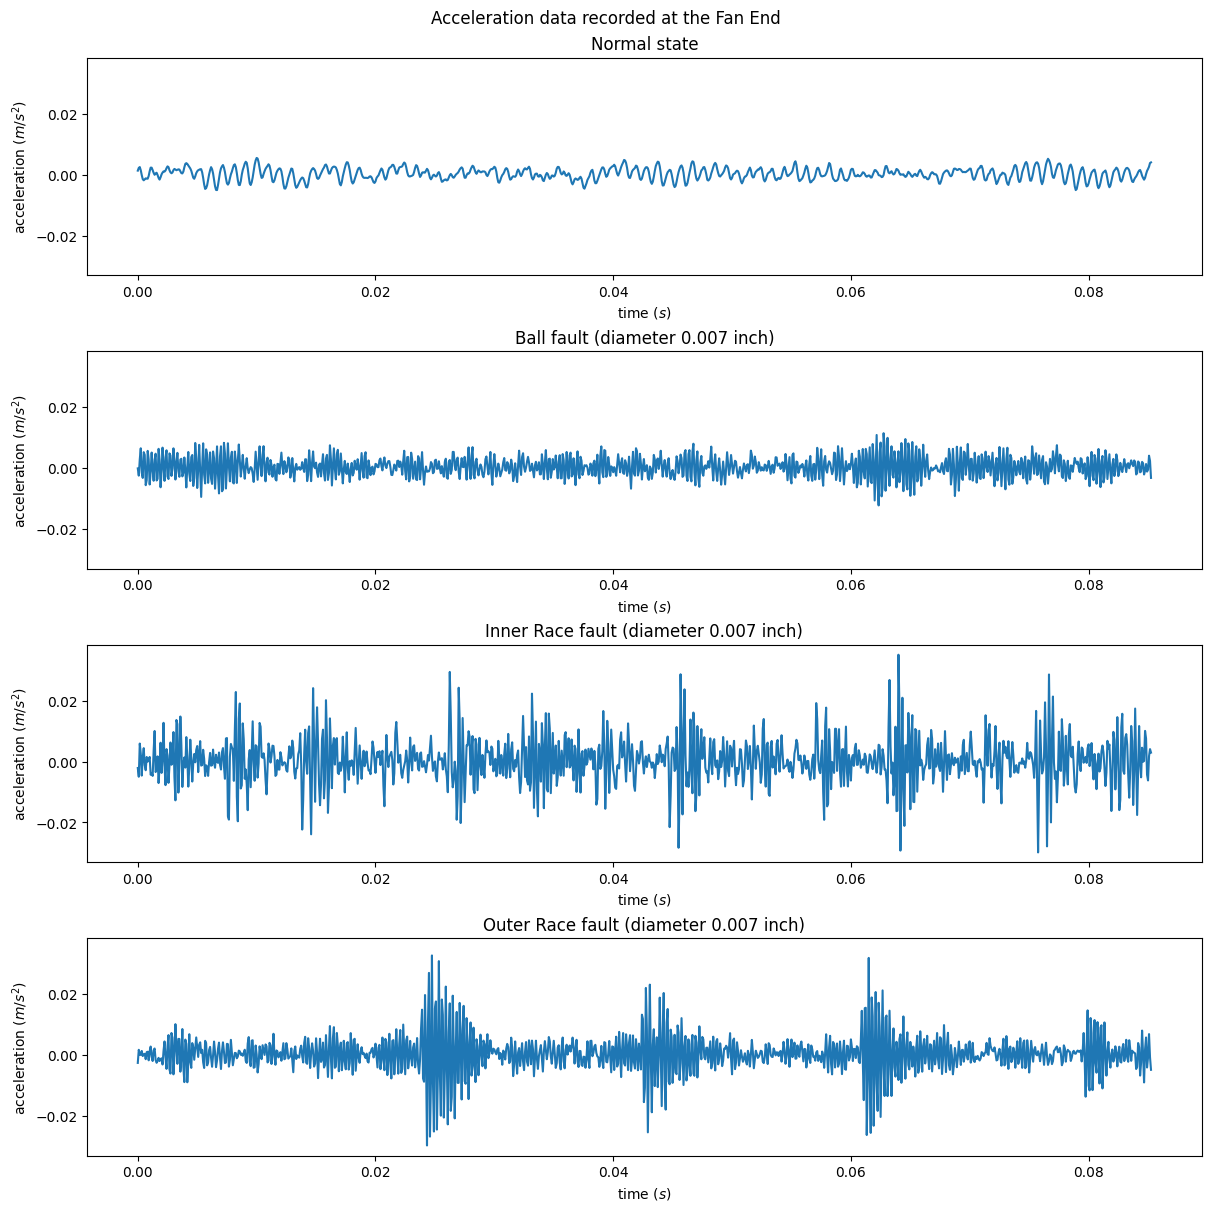

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt

range_of_samples = np.arange(0,1024)
fs = 12000

# plotting
fig, axs = plt.subplots(4, 1, sharey=True, figsize=(12, 12), constrained_layout=True)
fig.suptitle('Acceleration data recorded at the Fan End')

axs[0].plot(range_of_samples/fs, G_data_N_DE_DATASET_A[range_of_samples])
axs[0].set_title('Normal state')

axs[1].plot(range_of_samples/fs, G_data_B_007_DE_DATASET_A[range_of_samples])
axs[1].set_title('Ball fault (diameter 0.007 inch)')

axs[2].plot(range_of_samples/fs, G_data_IR_007_DE_DATASET_A[range_of_samples])
axs[2].set_title('Inner Race fault (diameter 0.007 inch)')

axs[3].plot(range_of_samples/fs, G_data_OR_007_DE_DATASET_A[range_of_samples])
axs[3].set_title('Outer Race fault (diameter 0.007 inch)')

for ax in axs.flat:
    ax.set(xlabel='time $(s)$', ylabel='acceleration $(m/s^2)$')

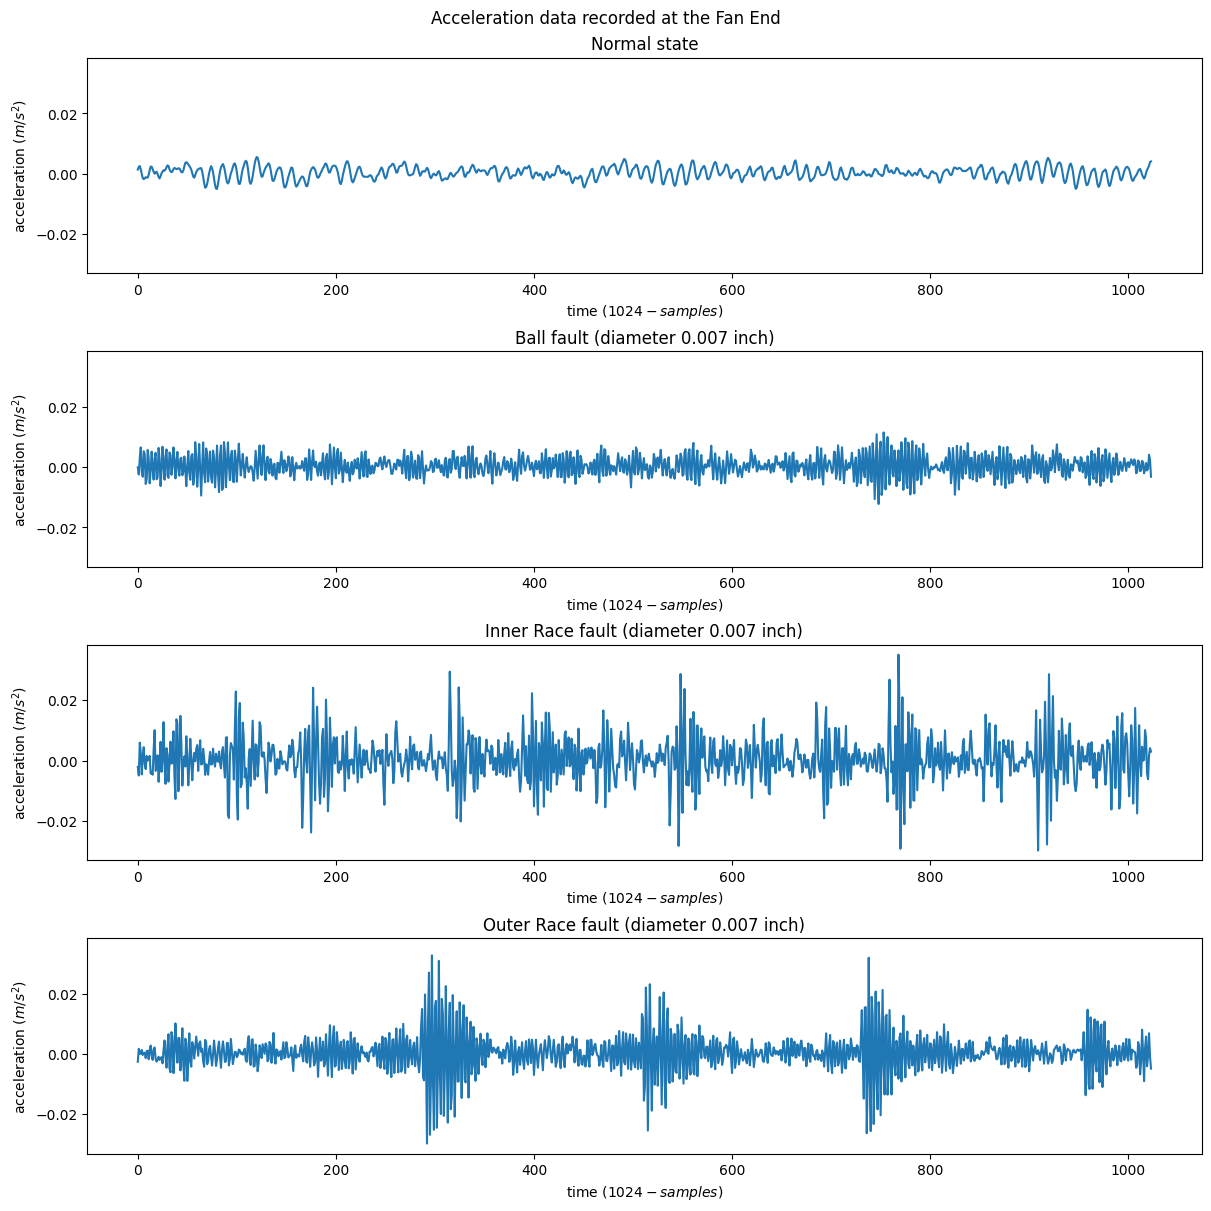

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt

range_of_samples = np.arange(0,1024)
fs = 12000

# plotting
fig, axs = plt.subplots(4, 1, sharey=True, figsize=(12, 12), constrained_layout=True)
fig.suptitle('Acceleration data recorded at the Fan End')

axs[0].plot(G_data_N_DE_DATASET_A[range_of_samples])
axs[0].set_title('Normal state')

axs[1].plot(G_data_B_007_DE_DATASET_A[range_of_samples])
axs[1].set_title('Ball fault (diameter 0.007 inch)')

axs[2].plot(G_data_IR_007_DE_DATASET_A[range_of_samples])
axs[2].set_title('Inner Race fault (diameter 0.007 inch)')

axs[3].plot(G_data_OR_007_DE_DATASET_A[range_of_samples])
axs[3].set_title('Outer Race fault (diameter 0.007 inch)')

for ax in axs.flat:
    ax.set(xlabel='time $(1024-samples)$', ylabel='acceleration $(m/s^2)$')

## 4. Architecture of the CNN
As the picture in our blogpost shows , we can distinguish 3 main conceptual phases.

1. Data chunking
2. Data labeling `give the data a label 0,1,2 and 3`
2. Data shuffling
3. Convolutional Neural Network

### 4.1. Data chunking
We'll divide the signal in chunks of size `chunk_size`, and take a subset `number_of_chunks` from all the available for training and testing the CNN. A chunk is simply a sequential subset of the time series data with a fixed length - the `chunk_size`. Every chunk is distinct - there are no overlapping samples in different chunks. This method is said tumbling time windowing, for more info you can see this [blog post](https://blog.codecentric.de/en/2018/10/window-functions-in-stream-analytics/). Each time series is an array, and they have slight difference in length. This means that if we fix a chunk size to divide the file, we need a function to split the data exaclty in `number_of_chunks` of `chunk_size` and get rid of the remaining part. We can write a function for that, `split_exact`, which takes the array to be splitted, the number of chunks and the array axis to be splitted.

In [19]:
def split_exact(x, n_chunks=2, axis=1):

    # L = Length of x
    l = np.shape(x)[axis]
    print("length of x: ", l)

    # x_split = x
    x_split = x
    if l > n_chunks > 1:
        n = n_chunks
        print("number of chunks is :", n)
        if axis == 0:
            # x_split returns list of ndarrays A list of sub-arrays
            x_split = np.split(x[:-(l % n)], n, axis=axis)
            print("number of sub arrays: ", len(x_split))
        elif axis == 1:
            x_split = np.split(x[:, :-(l % n)], n,  axis=axis)
    return x_split

Some operations were performed on the data.

For the CWRU Data only - ignoring the 0.028 inch fault diameter from `IR` and `B`, only considering the rest:

* the **normal** data labelled as `N` - Baseline

* the **inner raceway** data labelled as `IR`
      1.for 0.007 inch fault diameter
      2.for 0.014 inch fault diameter
      3.for 0.021 inch fault diameter
* the **ball** data labelled as `B`
      1.for 0.007 inch fault diameter
      2.for 0.014 inch fault diameter
      3.for 0.021 inch fault diameter
* the **outer raceway** data labelled as `OR`
      1.for 0.007 inch fault diameter
      2.for 0.014 inch fault diameter
      3.for 0.021 inch fault diameter

For every load, the data is joined from `0...3` HP load, normalizing it with respect to the *standard deviation*. This is because the load is not considered in *Classification*.

Several functions needed, such as; `load_raw_matlab_data` which returns several multidimensional arrays for `N`, `IR`, `B` and `OR` data with dimension of the maximum `number_of_chunks` obtainable from the data, by `chunk_size`.

In [20]:
def split_sig_by_Bs(sig, Fs, Bs):
    if sig.ndim == 2:
       raise Exception("The number of dimensions exceeds 1")

    elif sig.ndim == 1:
       print("1D Signal Shape")
       L = len(sig)          # length of the signal
       # print(L)
       single_sample = len(np.arange(0, Bs))
       num_splits = L // single_sample
       # print(num_splits)
       last = int(num_splits * single_sample)
       # print(last)
       x_new = sig[:last]
       # print(len(x_new))
       # print(single_sample)
       x_new = np.array_split(x_new, single_sample)
       x_new = np.array(x_new)
       print(f'Signal name {namestr(sig, globals())}, Signal Original shape: {sig.shape} The output Shape: {x_new.shape}')

    return x_new

def namestr(obj, namespace):
    return [name for name in namespace if namespace[name] is obj]

Initializing the data using the latter function.

### 4.1.1 Source Domain data chunk



In [21]:
Fs = 12000                # sampling frequency
Bs = 1024                 # chunk size

# Level #1
G_data_N_DE_DATASET_A      =  split_sig_by_Bs(G_data_N_DE_DATASET_A, Fs, Bs)
G_data_faulty_DATASET_A    =  split_sig_by_Bs(G_data_faulty_DATASET_A, Fs, Bs)

# Level #2
# G_data_N_DE_1     =     split_sig_fixed_5s_cycle(G_data_N_DE, Fs)
G_data_B_DE_DATASET_A      =   split_sig_by_Bs(G_data_B_DE_DATASET_A, Fs, Bs)
G_data_IR_DE_DATASET_A     =   split_sig_by_Bs(G_data_IR_DE_DATASET_A, Fs, Bs)
G_data_OR_DE_DATASET_A     =   split_sig_by_Bs(G_data_OR_DE_DATASET_A, Fs, Bs)

# Level #3
# G_data_N_DE_1     =     split_sig_fixed_5s_cycle(G_data_N_DE, t)
G_data_B_007_DE_DATASET_A  = split_sig_by_Bs(G_data_B_007_DE_DATASET_A, Fs, Bs)
G_data_B_014_DE_DATASET_A  = split_sig_by_Bs(G_data_B_014_DE_DATASET_A, Fs, Bs)
G_data_B_021_DE_DATASET_A  = split_sig_by_Bs(G_data_B_021_DE_DATASET_A, Fs, Bs)

G_data_IR_007_DE_DATASET_A = split_sig_by_Bs(G_data_IR_007_DE_DATASET_A, Fs, Bs)
G_data_IR_014_DE_DATASET_A = split_sig_by_Bs(G_data_IR_014_DE_DATASET_A, Fs, Bs)
G_data_IR_021_DE_DATASET_A = split_sig_by_Bs(G_data_IR_021_DE_DATASET_A, Fs, Bs)

G_data_OR_007_DE_DATASET_A = split_sig_by_Bs(G_data_OR_007_DE_DATASET_A, Fs, Bs)
G_data_OR_014_DE_DATASET_A = split_sig_by_Bs(G_data_OR_014_DE_DATASET_A, Fs, Bs)
G_data_OR_021_DE_DATASET_A = split_sig_by_Bs(G_data_OR_021_DE_DATASET_A, Fs, Bs)

1D Signal Shape
Signal name ['G_data_N_DE_DATASET_A'], Signal Original shape: (243938,) The output Shape: (1024, 238)
1D Signal Shape
Signal name ['G_data_faulty_DE', 'G_data_faulty_DATASET_A'], Signal Original shape: (1586027,) The output Shape: (1024, 1548)
1D Signal Shape
Signal name ['G_data_B_DE', 'G_data_B_DE_DATASET_A'], Signal Original shape: (366408,) The output Shape: (1024, 357)
1D Signal Shape
Signal name ['G_data_IR_DE', 'G_data_IR_DE_DATASET_A'], Signal Original shape: (365247,) The output Shape: (1024, 356)
1D Signal Shape
Signal name ['G_data_OR_DE', 'G_data_OR_DE_DATASET_A'], Signal Original shape: (854372,) The output Shape: (1024, 834)
1D Signal Shape
Signal name ['G_data_B_007_DE', 'G_data_B_007_DE_DATASET_A'], Signal Original shape: (122571,) The output Shape: (1024, 119)
1D Signal Shape
Signal name ['G_data_B_014_DE', 'G_data_B_014_DE_DATASET_A'], Signal Original shape: (121846,) The output Shape: (1024, 118)
1D Signal Shape
Signal name ['G_data_B_021_DE', 'G_data

### 4.2 Data labeling
`give the data a label 0,1,2 and 3`

This study focuses on the classification of the drive end bearing defects using only the signal data at **DE**. It is a **multiclass classification** problem. The input is the vibration signal data at DE and the output is the type of defects:

`- 0 : Normal (N), `

`- 1 : Fault at Ball (B),`

`- 2 : Fault at Inner Raceway (IR), `

`- 3 : Fault at Outer Raceway (OR), `


In [22]:
d_n = (G_data_N_DE_DATASET_A.shape[1], )
print("Normal data shape: ", d_n)
y_noraml = np.zeros(d_n, dtype=int)
print("label 0 for normal data ", y_noraml.shape)
print(type(y_noraml))

d_b = (G_data_B_DE_DATASET_A.shape[1], )
y_ball = np.ones(d_b, dtype=int)
print("label 1 for faulty ball bearing data ", y_ball.shape)
print(type(y_ball))

d_ir = (G_data_IR_DE_DATASET_A.shape[1], )
y_ir = np.ones(d_ir, dtype=int) * 2
print("label 2 for faulty inner raceway data ", y_ir.shape)
print(type(y_ir))

d_or = (G_data_OR_DE_DATASET_A.shape[1], )
y_or = np.ones(d_or, dtype=int) * 3
print("label 3 for faulty outer raceway data ", y_or.shape)
print(type(y_or))
print('----------------------------------------')

print("label 0 for normal data: ", y_noraml[0])
print("label 1 for faulty ball bearing data: ", y_ball[0])
print("label 2 for faulty inner raceway data: ", y_ir[0])
print("label 3 for faulty outer raceway data: ", y_or[0])

Normal data shape:  (238,)
label 0 for normal data  (238,)
<class 'numpy.ndarray'>
label 1 for faulty ball bearing data  (357,)
<class 'numpy.ndarray'>
label 2 for faulty inner raceway data  (356,)
<class 'numpy.ndarray'>
label 3 for faulty outer raceway data  (834,)
<class 'numpy.ndarray'>
----------------------------------------
label 0 for normal data:  0
label 1 for faulty ball bearing data:  1
label 2 for faulty inner raceway data:  2
label 3 for faulty outer raceway data:  3


In [23]:
# convert a list to numpy array
normal = np.reshape(G_data_N_DE_DATASET_A, (-1, 1024))
ball = np.reshape(G_data_B_DE_DATASET_A, (-1, 1024))
inner_race = np.reshape(G_data_IR_DE_DATASET_A, (-1, 1024))
outer_race = np.reshape(G_data_OR_DE_DATASET_A, (-1, 1024))

# convert numpy array to torch tensor
normal = torch.from_numpy(normal)
ball = torch.from_numpy(ball)
inner_race = torch.from_numpy(inner_race)
outer_race = torch.from_numpy(outer_race)
print(type(normal))

# covert the label data to torch tensor
y_n = torch.from_numpy(y_noraml)
y_b = torch.from_numpy(y_ball)
y_inner_r = torch.from_numpy(y_ir)
y_out_r = torch.from_numpy(y_or)


# concatenate the data of normal, ball, inner_race, outer_race
X = torch.cat((normal, ball, inner_race, outer_race), dim=0)
print(X.shape)

# concatenate the label data of normal, ball, inner_race, outer_race
y = torch.cat((y_n, y_b, y_inner_r, y_out_r), dim=0)
print(y.shape)

<class 'torch.Tensor'>
torch.Size([1785, 1024])
torch.Size([1785])


In [24]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
import math

In [25]:
# set aside 20% of train and test data for evaluation
train = X
test = y
print(train.shape)
print(test.shape)



X_train, X_test, y_train, y_test = train_test_split(train, test,
    test_size=0.2, shuffle = True, random_state = 8)

# Use the same function above for the validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
    test_size=0.25, random_state= 8) # 0.25 x 0.8 = 0.2


print("X_train shape: {}, dtype: {}".format(X_train.shape, type(X_train)))
print("X_test shape: {}".format(X_test.shape))
print("y_train shape: {}".format(y_train.shape))
print("y_test shape: {}".format(y_test.shape))
print("X_val shape: {}".format(X_val.shape))
print("y_val shape: {}".format(y_val.shape))

torch.Size([1785, 1024])
torch.Size([1785])
X_train shape: torch.Size([1071, 1024]), dtype: <class 'torch.Tensor'>
X_test shape: torch.Size([357, 1024])
y_train shape: torch.Size([1071])
y_test shape: torch.Size([357])
X_val shape: torch.Size([357, 1024])
y_val shape: torch.Size([357])


In [26]:
from torch.utils.data import Dataset
import torch

In [27]:
# Functions for training
def get_dataloader(train_ds, valid_ds, test_ds, bs):
    '''
        Get dataloaders of the training and validation set.
        Parameter:
            train_ds: Dataset
                Training set
            valid_ds: Dataset
                Validation set
            bs: Int
                Batch size

        Return:
            (train_dl, valid_dl): Tuple of DataLoader
                Dataloaders of training and validation set.
    '''
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs, shuffle=True),
        DataLoader(test_ds, batch_size=bs, shuffle=True)
    )

In [28]:
## Create DataLoader of train and validation set
X_train = torch.tensor(X_train, dtype=torch.float32)
X_valid = torch.tensor(X_val, dtype=torch.float32)
y_train = torch.tensor(y_train)
y_valid = torch.tensor(y_val)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test)
print(X_train.shape, X_valid.shape, y_train.shape, y_valid.shape, X_test.shape, y_test.shape)

Bs= 1024  # Block Size or Chunk size

# add channel dimesion
X_train = X_train.view(-1, 1, Bs)
X_valid = X_valid.view(-1, 1, Bs)
X_test =   X_test.view(-1, 1, Bs)

print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)

train_ds = TensorDataset(X_train, y_train)
valid_ds = TensorDataset(X_valid, y_valid)
test_ds = TensorDataset(X_test, y_test)

# bs = batchsize = 64 as defined in the hyperparameters "look at the above cell"
bs = 32
train_dl, valid_dl, test_dl = get_dataloader(train_ds, valid_ds, test_ds, bs)
print(next(iter(train_dl))[0].shape)
print(next(iter(train_dl))[1].shape)
print(len(train_dl))
print(len(valid_dl))

torch.Size([1071, 1024]) torch.Size([357, 1024]) torch.Size([1071]) torch.Size([357]) torch.Size([357, 1024]) torch.Size([357])
torch.Size([1071, 1, 1024])
torch.Size([357, 1, 1024])
torch.Size([357, 1, 1024])
torch.Size([32, 1, 1024])
torch.Size([32])
34
12


/tmp/ipython-input-28-2315295834.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(X_train, dtype=torch.float32)
/tmp/ipython-input-28-2315295834.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_valid = torch.tensor(X_val, dtype=torch.float32)
/tmp/ipython-input-28-2315295834.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train)
/tmp/ipython-input-28-2315295834.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTens

# Training with Adams Optimizer

In [29]:
class CNN_1D_2L(nn.Module):
    def __init__(self, n_in):
        super().__init__()
        self.n_in = n_in
        # print("features are: ", n_in)
        self.layer1 = nn.Sequential(
            nn.Conv1d(1, 64, (9,), stride=1, padding=4),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.MaxPool1d(2,stride=2)
        )


        self.layer2 = nn.Sequential(
            nn.Conv1d(64, 128, (5,), stride=1, padding=2),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.AvgPool1d(2,stride=2)
        )

        self.linear1 = nn.Linear(self.n_in*128 //4, 4)


    def forward(self, x):
        # print("forward input shape", x.shape)
        # x = x.view(-1, 1, self.n_in)
        # print("x.view input shape", x.shape)
        x = self.layer1(x)
        x = self.layer2(x)
        x = x.view(-1, self.n_in*128//4)
        # print("x.view(-1, self.n_in*128//4)", x.shape)
        return self.linear1(x)

# 3 Layers CNN
class CNN_1D_3L(nn.Module):
    def __init__(self, n_in):
        super().__init__()
        self.n_in = n_in
        self.layer1 = nn.Sequential(
            nn.Conv1d(1, 64, (9,), stride=1, padding=4),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.MaxPool1d(2,stride=2)
        )

        self.layer2 = nn.Sequential(
            nn.Conv1d(64, 64, (5,), stride=1, padding=2),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.MaxPool1d(2,stride=2)
        )

        self.layer3 = nn.Sequential(
            nn.Conv1d(64, 128, (5,), stride=1, padding=2),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.MaxPool1d(2,stride=2)
        )

        self.linear1 = nn.Linear(self.n_in*128 //8, 4)


    def forward(self, x):

        # x = x.view(-1, 1, self.n_in)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = x.view(-1, self.n_in*128//8)
        # print("from forward method x", x)
        return self.linear1(x) #print('print self.linear1(x) ', self.linear1(x)))


In [30]:
## Instantiate model, optimizer and loss function
features = X_train.shape[2]
print(X_train.shape[2])
# print(features)
model = CNN_1D_2L(features)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)
# From the output you can see that the fully connected layer takes (32768, 4) 4=number of classes

1024


CNN_1D_2L(
  (layer1): Sequential(
    (0): Conv1d(1, 64, kernel_size=(9,), stride=(1,), padding=(4,))
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv1d(64, 128, kernel_size=(5,), stride=(1,), padding=(2,))
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
  )
  (linear1): Linear(in_features=32768, out_features=4, bias=True)
)

In [31]:
from torch.optim import lr_scheduler

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.01)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1, verbose=True)

# num_epochs
epochs = 35

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [52]:
import pandas as pd

def loss_batch(model, loss_func, xb, yb, opt=None):

    '''
        Parameter:
            model: Module
                Your neural network model
            loss_func: Loss
                Loss function, e.g. CrossEntropyLoss()
            xb: Tensor
                One batch of input x
            yb: Tensor
                One batch of true label y
            opt: Optimizer
                Optimizer, e.g. SGD()

        Return:
            loss.item(): Python number
                Loss of the current batch
            len(xb): Int
                Number of examples of the current batch
            pred: ndarray
                Predictions (class with highest probability) of the minibatch
                input xb
    '''
    out = model(xb)
    # print('out.shape', out.shape)
    pred = torch.argmax(out, dim=1).cpu()
    # print("pred.shape", pred.shape)
    loss = loss_func(out, yb)
    # print("loss", loss)


    if opt is not None:

        loss.backward()
        opt.step()
        opt.zero_grad()


    return loss.item(), len(xb), pred

def fit(epochs, model, loss_func, opt, train_dl, valid_dl, train_metric=False, schedular=None):
    '''
        Train the NN model and return the model at the final step.
        Lists of the training and validation losses at each epochs are also
        returned.

        Parameter:
            epochs: int
                Number of epochs to run.
            model: Module
                Your neural network model
            loss_func: Loss
                Loss function, e.g. CrossEntropyLoss()
            opt: Optimizer
                Optimizer, e.g. SGD()
            train_dl: DataLoader
                Dataloader of the training set.
            valid_dl: DataLoader
                Dataloader of the validation set.
            train_metric: Bool
                Default is False. If False, the train loss and accuracy will be
                set to 0.
                If True, the loss and accuracy of the train set will also be
                computed.

        Return:
            model: Module
                Trained model.
            metrics: DataFrame
                DataFrame which contains the train and validation loss at each
                epoch.
    '''
    print(
        'EPOCH', '\t',
        'Train Loss', '\t',
        'Val Loss', '\t',
        'Train Acc', '\t',
        'Val Acc', '\t')
    # Initialize dic to store metrics for each epoch.
    metrics_dic = {}
    metrics_dic['train_loss'] = []
    metrics_dic['train_accuracy'] = []
    metrics_dic['val_loss'] = []
    metrics_dic['val_accuracy'] = []

    # early_stopping = EarlyStopping(patience=patience, verbose=True)

    for epoch in range(epochs):
        # Train
        model.train()
        train_loss = 0.0
        train_accuracy = 0.0
        num_examples = 0

        # Initialize hidden and cell states for LSTM at the beginning of each epoch
        # This is not strictly necessary for a stateless LSTM where batch_first=True,
        # but it's good practice if states were to be carried across batches.
        # If the LSTM is stateful, these would need to be initialized per batch.
        # For this stateless example, the forward method handles state initialization per batch.
        # if isinstance(model, LSTM):
        #     h0 = torch.zeros(model.num_layers, train_dl.batch_size, model.hidden_size).to(device)
        #     c0 = torch.zeros(model.num_layers, train_dl.batch_size, model.hidden_size).to(device)


        for xb, yb in train_dl:
            xb, yb = xb.to(device), yb.to(device)
            #print("xb, yb shapes", xb.shape, yb.shape)
            #print("model(xb).shape", model(xb).shape)
            # yb = yb.view(1, -1)
            loss, batch_size, pred = loss_batch(model, loss_func, xb, yb, opt)
            if train_metric == False:
                train_loss += loss
                num_examples += batch_size

        # Validate
        model.eval()
        with torch.no_grad():
            val_loss, val_accuracy, _ = validate(model, valid_dl, loss_func)

            if train_metric:
                train_loss, train_accuracy, _ = validate(model, train_dl, loss_func)
                ##########################
                if schedular is not None:
                    schedular.step()
                ##########################
            else:
                train_loss = train_loss / num_examples

        metrics_dic['val_loss'].append(val_loss)
        metrics_dic['val_accuracy'].append(val_accuracy)
        metrics_dic['train_loss'].append(train_loss)
        metrics_dic['train_accuracy'].append(train_accuracy)

        print(
            f'{epoch} \t',
            f'{train_loss:.05f}', '\t',
            f'{val_loss:.05f}', '\t',
            f'{train_accuracy:.05f}', '\t'
            f'{val_accuracy:.05f}', '\t')

    metrics = pd.DataFrame.from_dict(metrics_dic)

    return model, metrics

def validate(model, dl, loss_func):
    total_loss = 0.0
    total_size = 0
    predictions = []
    y_true = []
    for xb, yb in dl:
        xb, yb = xb.to(device), yb.to(device)

        # Check if the model is an LSTM model
        if isinstance(model, LSTM):
             # For LSTM, the forward method handles the initial hidden and cell states
            loss, batch_size, pred = loss_batch(model, loss_func, xb, yb)
        else:
            # For other models (like CNN), use the original loss_batch call
            loss, batch_size, pred = loss_batch(model, loss_func, xb, yb)

        total_loss += loss*batch_size
        total_size += batch_size
        predictions.append(pred)
        y_true.append(yb.cpu().numpy())
    mean_loss = total_loss / total_size

    predictions = np.concatenate(predictions, axis=0)
    y_true = np.concatenate(y_true, axis=0)
    accuracy = np.mean((predictions == y_true))

    return mean_loss, accuracy, (y_true, predictions)

In [33]:
import time
tic = time.time()
## Train
epochs = 35
model, metrics = fit(epochs, model, criterion, optimizer_ft, train_dl, valid_dl, train_metric=True, schedular= exp_lr_scheduler)
toc = time.time()
print(toc-tic)

EPOCH 	 Train Loss 	 Val Loss 	 Train Acc 	 Val Acc 	
0 	 21.72126 	 21.74266 	 0.13445 	0.13445 	
1 	 8.13819 	 8.35924 	 0.13819 	0.13445 	
2 	 0.45366 	 0.61141 	 0.79925 	0.73669 	
3 	 0.64798 	 0.83046 	 0.76284 	0.70588 	
4 	 0.69554 	 0.87093 	 0.74323 	0.68627 	
5 	 0.53095 	 0.75415 	 0.76844 	0.70588 	
6 	 0.42848 	 0.60252 	 0.81886 	0.73389 	
7 	 0.23295 	 0.40321 	 0.90289 	0.80672 	
8 	 0.31496 	 0.48817 	 0.85808 	0.78992 	
9 	 0.47310 	 0.73410 	 0.81513 	0.74230 	
10 	 0.02322 	 0.11367 	 1.00000 	0.95518 	
11 	 0.02779 	 0.12880 	 1.00000 	0.94398 	
12 	 0.02208 	 0.11336 	 1.00000 	0.96359 	
13 	 0.02386 	 0.11552 	 1.00000 	0.95798 	
14 	 0.02867 	 0.13097 	 1.00000 	0.94958 	
15 	 0.02296 	 0.11908 	 1.00000 	0.94958 	
16 	 0.02309 	 0.11971 	 1.00000 	0.94678 	
17 	 0.01727 	 0.09917 	 1.00000 	0.96639 	
18 	 0.02371 	 0.12020 	 1.00000 	0.95238 	
19 	 0.02147 	 0.11185 	 1.00000 	0.95518 	
20 	 0.01515 	 0.09175 	 1.00000 	0.97199 	
21 	 0.01908 	 0.10533 	 1.000

In [34]:
import os
from pathlib import Path

In [35]:
working_dir = Path('../content/drive/MyDrive')
DATA_PATH = Path("../content/drive/MyDrive/Data")
save_model_path = working_dir / 'Ball_bearing_fault_diagnosis'

for path in [DATA_PATH, save_model_path]:
    if not path.exists():
        path.mkdir(parents=True)

In [36]:
# CHange this value to your last accuracy found after running "train"
                                                              ###################
torch.save(model.state_dict(), save_model_path / f'model_1D_CNN_1{str(0.96919)}_model.pth' )

In [38]:
# ---------- AFTER TRAINING YOU NEED TO SAVE UP YOUR MODEL METRICS FOR LATER VISULIZATIONS ------------------- #
metrics.to_csv(r'/model_1D_CNN_1_0.96919.csv', index=False)

In [39]:
# ----------- I HAVE ALREADY SAVED MY METRICS dataframe INTO A CSV file IN MY DRIVE --------- #
# ----------- here is a link: https://drive.google.com/file/d/18dTgPtfA6Fp0U3znaCtz0EzAvJX0O6i-/view?usp=sharing
metrics_1D_CNN_1 = pd.read_csv('/model_1D_CNN_1_0.96919.csv').to_dict()
print(metrics_1D_CNN_1)

{'train_loss': {0: 21.72125602102413, 1: 8.13818563511169, 2: 0.4536598700296088, 3: 0.647981634827889, 4: 0.6955421174051158, 5: 0.5309504760302304, 6: 0.4284803927028212, 7: 0.2329505348906797, 8: 0.3149633055238051, 9: 0.4731008412679927, 10: 0.0232174486116646, 11: 0.0277921949449342, 12: 0.0220788278426526, 13: 0.0238619956051379, 14: 0.0286659153472253, 15: 0.0229613429594551, 16: 0.0230949670337244, 17: 0.017265012983431, 18: 0.0237106894143795, 19: 0.0214730902426257, 20: 0.0151473301520221, 21: 0.0190813415670762, 22: 0.0121619949755576, 23: 0.0173703681201048, 24: 0.0160332932202171, 25: 0.0131218641184193, 26: 0.0168431524142108, 27: 0.0175497670363144, 28: 0.0163723236188139, 29: 0.0168394445482751, 30: 0.0155612147075361, 31: 0.018258426220171, 32: 0.0176317434858819, 33: 0.0141951653055923, 34: 0.0169317813278858}, 'train_accuracy': {0: 0.134453781512605, 1: 0.138188608776844, 2: 0.7992530345471522, 3: 0.7628384687208216, 4: 0.7432306255835668, 5: 0.7684407096171803, 6: 0

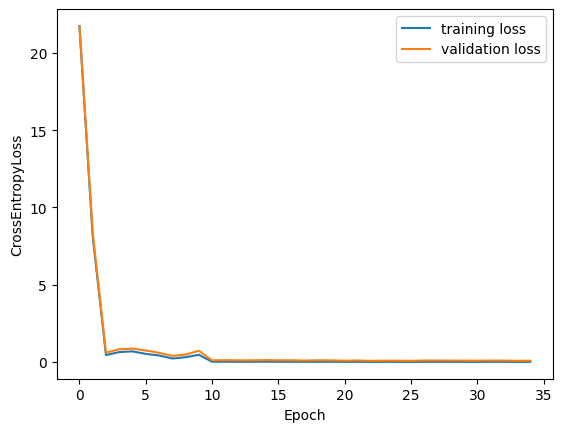

In [40]:
plt.plot(np.array(list(metrics_1D_CNN_1['train_loss'].values())).astype(float), label='training loss')
plt.plot(np.array(list(metrics_1D_CNN_1['val_loss'].values())).astype(float), label='validation loss')
plt.xlabel('Epoch')
plt.ylabel('CrossEntropyLoss')
plt.legend()

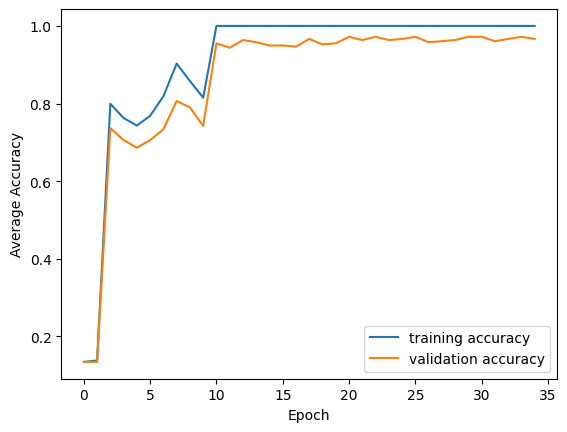

In [41]:
plt.plot(np.array(list(metrics_1D_CNN_1['train_accuracy'].values())).astype(float), label='training accuracy')
plt.plot(np.array(list(metrics_1D_CNN_1['val_accuracy'].values())).astype(float), label='validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Average Accuracy')
plt.legend()

In [42]:
load_path = '/content/drive/MyDrive/Ball_bearing_fault_diagnosis/model_1D_CNN_10.96919_model.pth'
model_checkpoint = torch.load(load_path)
# if the model is not defined it shoudlbe define again here before
# the method model.load_state_dict() is called

In [43]:
## Instantiate model, optimizer and loss function
features = X_train.shape[2]
print(X_train.shape[2])
# print(features)
model_1D_CNN_2 = CNN_1D_2L(features)
model_1D_CNN_2 = model_1D_CNN_2.to(device)


1024


In [44]:
model_1D_CNN_2.load_state_dict(model_checkpoint)

<All keys matched successfully>

In [45]:
import time
tic = time.time()
mean_loss, accuracy, (y_true, predictions) = validate(model_1D_CNN_2, test_dl, criterion)
print(mean_loss, accuracy)
toc = time.time()
print(toc-tic)

0.10120086534684446 0.9607843137254902
1.9092507362365723


# 4. Training with LSTM

In [53]:
# Define the LSTM model
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        # batch_first=True allows input and output tensors of shape (batch_size, seq_length, input_size)
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # Initialize hidden and cell states
        # Shape: (num_layers * num_directions, batch_size, hidden_size)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)

        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))  # out: tensor of shape (batch_size, seq_length, hidden_size)

        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out

### 4.3.1 Prepare Data for LSTM
Since the LSTM layer expects input in the shape `(batch_size, seq_length, input_size)` and our current data `X_train`, `X_valid`, and `X_test` are of shape `(batch_size, 1, chunk_size)`, we need to remove the dimension of size 1 (the channel dimension) to get the shape `(batch_size, chunk_size)`. In the context of a simple LSTM where each chunk is treated as a single sequence with `chunk_size` features at one time step, the `seq_length` would be 1 and the `input_size` would be `chunk_size`. However, a more typical use case for LSTM with this type of data would be to treat the `chunk_size` as the `seq_length` and the input features at each time step as 1. We will proceed with the latter interpretation, reshaping the data to `(batch_size, chunk_size, 1)`.

In [54]:
# Need to reshape the input data for LSTM.
# LSTM expects input shape (batch_size, seq_length, input_size)
# We will treat chunk_size as seq_length and 1 as input_size
X_train_lstm = X_train.permute(0, 2, 1)
X_valid_lstm = X_valid.permute(0, 2, 1)
X_test_lstm = X_test.permute(0, 2, 1)


print("Reshaped data shapes for LSTM:")
print("X_train_lstm shape:", X_train_lstm.shape)
print("X_valid_lstm shape:", X_valid_lstm.shape)
print("X_test_lstm shape:", X_test_lstm.shape)

# Create DataLoader for LSTM
train_ds_lstm = TensorDataset(X_train_lstm, y_train)
valid_ds_lstm = TensorDataset(X_valid_lstm, y_valid)
test_ds_lstm = TensorDataset(X_test_lstm, y_test)

# bs = batchsize = 32
train_dl_lstm = DataLoader(train_ds_lstm, batch_size=bs, shuffle=True)
valid_dl_lstm = DataLoader(valid_ds_lstm, batch_size=bs, shuffle=True)
test_dl_lstm = DataLoader(test_ds_lstm, batch_size=bs, shuffle=True)


print("\nLSTM DataLoaders:")
print(next(iter(train_dl_lstm))[0].shape)
print(next(iter(train_dl_lstm))[1].shape)
print(len(train_dl_lstm))
print(len(valid_dl_lstm))

Reshaped data shapes for LSTM:
X_train_lstm shape: torch.Size([1071, 1024, 1])
X_valid_lstm shape: torch.Size([357, 1024, 1])
X_test_lstm shape: torch.Size([357, 1024, 1])

LSTM DataLoaders:
torch.Size([32, 1024, 1])
torch.Size([32])
34
12


### 4.3.2 Instantiate LSTM Model and Train

In [55]:
# Hyperparameters
input_size = 1 # The number of features at each time step
hidden_size = 128
num_layers = 2
num_classes = 4  # Number of fault classes (Normal, Ball, IR, OR)
learning_rate = 0.01
num_epochs = 35
# batch_size is already defined as bs

# Instantiate the LSTM model
lstm_model = LSTM(input_size, hidden_size, num_layers, num_classes).to(device)

# Loss and optimizer
criterion_lstm = nn.CrossEntropyLoss()
optimizer_lstm = optim.Adam(lstm_model.parameters(), lr=learning_rate)
exp_lr_scheduler_lstm = lr_scheduler.StepLR(optimizer_lstm, step_size=10, gamma=0.1, verbose=True)


# Training the LSTM model
print("\nStarting LSTM training...")
tic_lstm = time.time()
# The fit function is designed to handle both CNN and LSTM,
# but the LSTM forward method now handles the initial hidden and cell states.
lstm_model, metrics_lstm = fit(num_epochs, lstm_model, criterion_lstm, optimizer_lstm, train_dl_lstm, valid_dl_lstm, train_metric=True, schedular=exp_lr_scheduler_lstm)
toc_lstm = time.time()
print(f"\nLSTM Training time: {toc_lstm - tic_lstm:.2f} seconds")

# Save the LSTM model
torch.save(lstm_model.state_dict(), save_model_path / f'model_LSTM_{metrics_lstm["val_accuracy"].iloc[-1]:.5f}_model.pth')
metrics_lstm.to_csv(save_model_path / f'metrics_LSTM_{metrics_lstm["val_accuracy"].iloc[-1]:.5f}.csv', index=False)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Starting LSTM training...
EPOCH 	 Train Loss 	 Val Loss 	 Train Acc 	 Val Acc 	
0 	 1.27111 	 1.25868 	 0.46779 	0.48459 	
1 	 1.26832 	 1.25254 	 0.46779 	0.48459 	
2 	 1.27429 	 1.25780 	 0.46779 	0.48459 	
3 	 1.27408 	 1.26260 	 0.46779 	0.48459 	
4 	 1.26931 	 1.25706 	 0.46779 	0.48459 	
5 	 1.26870 	 1.25487 	 0.46779 	0.48459 	
6 	 1.27207 	 1.26135 	 0.46779 	0.48459 	
7 	 1.26803 	 1.25321 	 0.46779 	0.48459 	
8 	 1.26916 	 1.25408 	 0.46779 	0.48459 	
9 	 1.26795 	 1.25432 	 0.46779 	0.48459 	
10 	 1.26753 	 1.25345 	 0.46779 	0.48459 	
11 	 1.26740 	 1.25368 	 0.46779 	0.48459 	
12 	 1.26737 	 1.25354 	 0.46779 	0.48459 	
13 	 1.26737 	 1.25338 	 0.46779 	0.48459 	
14 	 1.26734 	 1.25355 	 0.46779 	0.48459 	
15 	 1.26738 	 1.25375 	 0.46779 	0.48459 	
16 	 1.26730 	 1.25371 	 0.46779 	0.48459 	
17 	 1.26729 	 1.25395 	 0.46779 	0.48459 	
18 	 1.26726 	 1.25355 	 0.46779 	0.48459 	
19 	 1.26712 	 1.25369 	 0.46779 	0.48459 	
20 	 1.26712 	 1.25372 	 0.46779 	0.48459 	


KeyboardInterrupt: 

### 4.3.3 Evaluate LSTM Model

In [ ]:
# Evaluate the trained LSTM model on the test set
print("\nEvaluating LSTM model on test set...")
tic_eval_lstm = time.time()
mean_loss_lstm, accuracy_lstm, (y_true_lstm, predictions_lstm) = validate(lstm_model, test_dl_lstm, criterion_lstm)
print(f"LSTM Test Loss: {mean_loss_lstm:.5f}, LSTM Test Accuracy: {accuracy_lstm:.5f}")
toc_eval_lstm = time.time()
print(f"LSTM Test Evaluation time: {toc_eval_lstm - tic_eval_lstm:.2f} seconds")

### 4.3.4 Visualize LSTM metrics

In [ ]:
# Plotting LSTM training and validation metrics
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(metrics_lstm['train_loss'], label='LSTM training loss')
plt.plot(metrics_lstm['val_loss'], label='LSTM validation loss')
plt.xlabel('Epoch')
plt.ylabel('CrossEntropyLoss')
plt.title('LSTM Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(metrics_lstm['train_accuracy'], label='LSTM training accuracy')
plt.plot(metrics_lstm['val_accuracy'], label='LSTM validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Average Accuracy')
plt.title('LSTM Training and Validation Accuracy')
plt.legend()
plt.tight_layout()
plt.show()